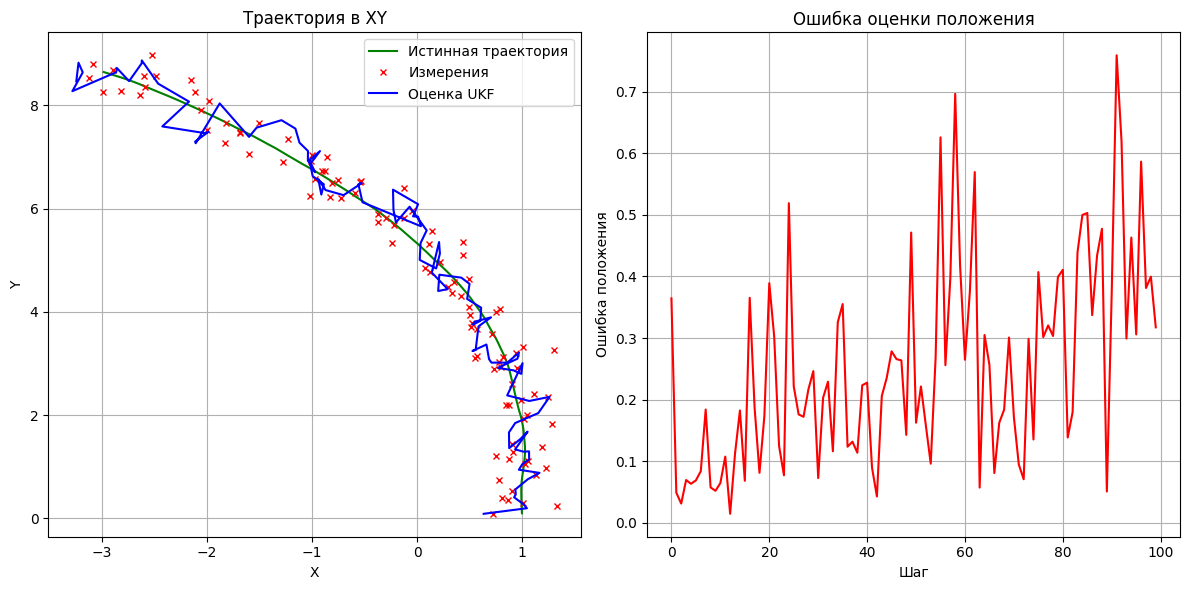

In [ ]:
import torch
import matplotlib.pyplot as plt
from filters import UnscentedKalmanFilter
from gaussian import GaussianState

# Параметры модели
dt = 0.1  # временной шаг
state_dim = 4  # [x, y, vx, vy]
obs_dim = 2    # [x, y]

# Создание UKF
ukf = UnscentedKalmanFilter(state_dim=state_dim, obs_dim=obs_dim, alpha=1e-3, beta=2.0, kappa=0.0)

# Нелинейная модель процесса (движение с постоянной скоростью + поворот)
def process_model(sigma_points):
    # sigma_points shape: (..., 2*state_dim+1, state_dim, 1)
    new_points = sigma_points.clone()
    
    # Извлечение компонент состояния
    x = sigma_points[..., 0, 0]
    y = sigma_points[..., 1, 0]
    vx = sigma_points[..., 2, 0]
    vy = sigma_points[..., 3, 0]
    
    # Нелинейное преобразование - добавление поворота скорости
    speed = torch.sqrt(vx**2 + vy**2)
    angle = torch.atan2(vy, vx)
    new_angle = angle + 0.1 * dt  # небольшой поворот
    
    # Обновление скорости после поворота
    new_points[..., 2, 0] = speed * torch.cos(new_angle)
    new_points[..., 3, 0] = speed * torch.sin(new_angle)
    
    # Обновление позиции
    new_points[..., 0, 0] = x + new_points[..., 2, 0] * dt
    new_points[..., 1, 0] = y + new_points[..., 3, 0] * dt
    
    return new_points

# Нелинейная модель измерений (радиальные координаты)
def measurement_model(sigma_points):
    # sigma_points shape: (..., 2*state_dim+1, state_dim, 1)
    measurements = torch.zeros(*sigma_points.shape[:-2], obs_dim, 1)
    
    x = sigma_points[..., 0, 0]
    y = sigma_points[..., 1, 0]
    
    # Преобразование в полярные координаты (нелинейное измерение)
    r = torch.sqrt(x**2 + y**2)
    theta = torch.atan2(y, x)
    
    measurements[..., 0, 0] = r
    measurements[..., 1, 0] = theta
    
    return measurements

# Шумы
process_noise = torch.diag(torch.tensor([0.1, 0.1, 0.5, 0.5]))**2  # Q
measurement_noise = torch.diag(torch.tensor([0.3, 0.02]))**2      # R

# Начальное состояние
initial_mean = torch.tensor([1.0, 0.0, 0.0, 1.0]).reshape(state_dim, 1)
initial_cov = torch.diag(torch.tensor([0.5, 0.5, 0.5, 0.5]))
initial_state = GaussianState(initial_mean, initial_cov)

# Генерация истинной траектории и измерений
num_steps = 100
true_states = torch.zeros(num_steps, state_dim, 1)
measurements = torch.zeros(num_steps, obs_dim, 1)

current_state = initial_mean.clone()
for t in range(num_steps):
    # Истинная динамика (с небольшим случайным поворотом)
    x, y, vx, vy = current_state.squeeze()
    speed = torch.sqrt(vx**2 + vy**2)
    angle = torch.atan2(vy, vx)
    new_angle = angle + 0.1 * dt + 0.02 * torch.randn(1)
    
    current_state[2] = speed * torch.cos(new_angle)
    current_state[3] = speed * torch.sin(new_angle)
    current_state[0] += current_state[2] * dt
    current_state[1] += current_state[3] * dt
    
    # Сохраняем истинное состояние
    true_states[t] = current_state.clone()
    
    # Генерируем измерение с шумом
    r = torch.sqrt(current_state[0]**2 + current_state[1]**2)
    theta = torch.atan2(current_state[1], current_state[0])
    measurements[t, 0] = r + measurement_noise[0, 0].sqrt() * torch.randn(1)
    measurements[t, 1] = theta + measurement_noise[1, 1].sqrt() * torch.randn(1)

# Запуск фильтра
estimated_means = torch.zeros(num_steps, state_dim, 1)
estimated_covs = torch.zeros(num_steps, state_dim, state_dim)

current_estimate = initial_state
for t in range(num_steps):
    # Predict-Update
    current_estimate = ukf.predict_update(
        current_estimate,
        measurements[t],
        process_model,
        process_noise,
        measurement_model,
        measurement_noise
    )
    
    # Сохраняем результаты
    estimated_means[t] = current_estimate.mean
    estimated_covs[t] = current_estimate.covariance

# Визуализация результатов
plt.figure(figsize=(12, 6))

# Траектория XY
plt.subplot(1, 2, 1)
plt.plot(true_states[:, 0, 0], true_states[:, 1, 0], 'g-', label='Истинная траектория')
plt.plot(measurements[:, 0, 0] * torch.cos(measurements[:, 1, 0]), 
         measurements[:, 0, 0] * torch.sin(measurements[:, 1, 0]), 
         'rx', label='Измерения', markersize=4)
plt.plot(estimated_means[:, 0, 0], estimated_means[:, 1, 0], 'b-', label='Оценка UKF')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Траектория в XY')
plt.legend()
plt.grid(True)

# Ошибки положения
position_errors = torch.sqrt((estimated_means[:, 0, 0] - true_states[:, 0, 0])**2 + 
                            (estimated_means[:, 1, 0] - true_states[:, 1, 0])**2)
plt.subplot(1, 2, 2)
plt.plot(position_errors, 'r-')
plt.xlabel('Шаг')
plt.ylabel('Ошибка положения')
plt.title('Ошибка оценки положения')
plt.grid(True)

plt.tight_layout()
plt.show()

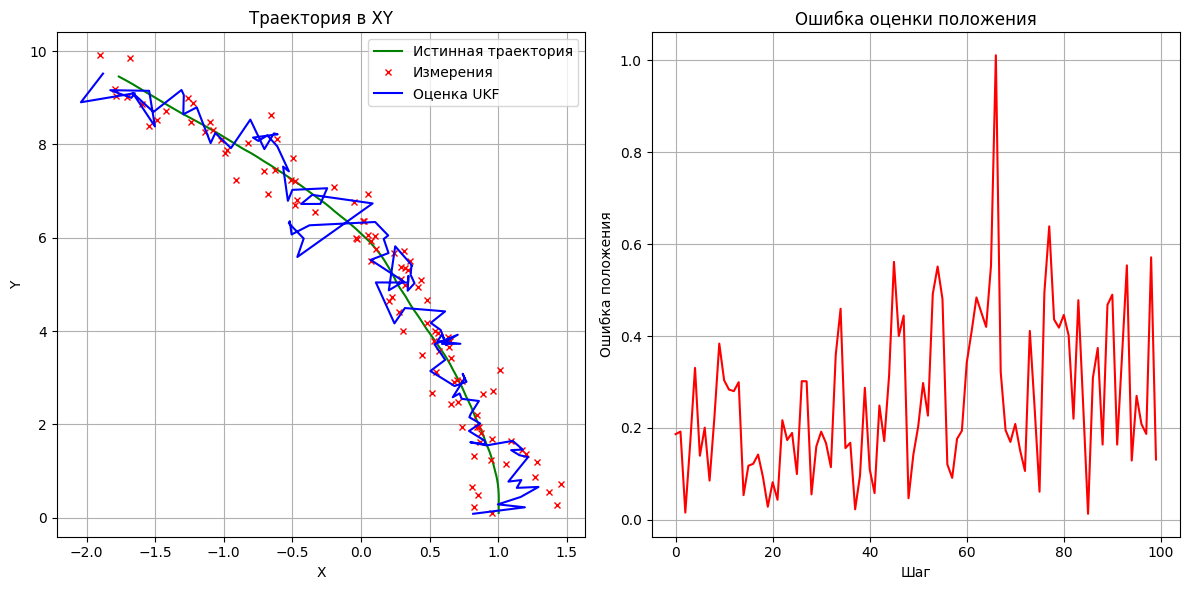

In [2]:
import torch
import matplotlib.pyplot as plt
from unscented import UnscentedKalmanFilter
from gaussian import GaussianState

# Параметры модели
dt = 0.1  # временной шаг
state_dim = 4  # [x, y, vx, vy]
obs_dim = 2    # [x, y]

# Создание UKF
ukf = UnscentedKalmanFilter(state_dim=state_dim, obs_dim=obs_dim, alpha=1e-3, beta=2.0, kappa=0.0)

# Нелинейная модель процесса (движение с постоянной скоростью + поворот)
def process_model(sigma_points):
    # sigma_points shape: (..., 2*state_dim+1, state_dim, 1)
    new_points = sigma_points.clone()
    
    # Извлечение компонент состояния
    x = sigma_points[..., 0, 0]
    y = sigma_points[..., 1, 0]
    vx = sigma_points[..., 2, 0]
    vy = sigma_points[..., 3, 0]
    
    # Нелинейное преобразование - добавление поворота скорости
    speed = torch.sqrt(vx**2 + vy**2)
    angle = torch.atan2(vy, vx)
    new_angle = angle + 0.1 * dt  # небольшой поворот
    
    # Обновление скорости после поворота
    new_points[..., 2, 0] = speed * torch.cos(new_angle)
    new_points[..., 3, 0] = speed * torch.sin(new_angle)
    
    # Обновление позиции
    new_points[..., 0, 0] = x + new_points[..., 2, 0] * dt
    new_points[..., 1, 0] = y + new_points[..., 3, 0] * dt
    
    return new_points

# Нелинейная модель измерений (радиальные координаты)
def measurement_model(sigma_points):
    # sigma_points shape: (..., 2*state_dim+1, state_dim, 1)
    measurements = torch.zeros(*sigma_points.shape[:-2], obs_dim, 1)
    
    x = sigma_points[..., 0, 0]
    y = sigma_points[..., 1, 0]
    
    # Преобразование в полярные координаты (нелинейное измерение)
    r = torch.sqrt(x**2 + y**2)
    theta = torch.atan2(y, x)
    
    measurements[..., 0, 0] = r
    measurements[..., 1, 0] = theta
    
    return measurements

# Шумы
process_noise = torch.diag(torch.tensor([0.1, 0.1, 0.5, 0.5]))**2  # Q
measurement_noise = torch.diag(torch.tensor([0.3, 0.02]))**2      # R

# Начальное состояние
initial_mean = torch.tensor([1.0, 0.0, 0.0, 1.0]).reshape(state_dim, 1)
initial_cov = torch.diag(torch.tensor([0.5, 0.5, 0.5, 0.5]))
initial_state = GaussianState(initial_mean, initial_cov)

# Генерация истинной траектории и измерений
num_steps = 100
true_states = torch.zeros(num_steps, state_dim, 1)
measurements = torch.zeros(num_steps, obs_dim, 1)

current_state = initial_mean.clone()
for t in range(num_steps):
    # Истинная динамика (с небольшим случайным поворотом)
    x, y, vx, vy = current_state.squeeze()
    speed = torch.sqrt(vx**2 + vy**2)
    angle = torch.atan2(vy, vx)
    new_angle = angle + 0.1 * dt + 0.02 * torch.randn(1)
    
    current_state[2] = speed * torch.cos(new_angle)
    current_state[3] = speed * torch.sin(new_angle)
    current_state[0] += current_state[2] * dt
    current_state[1] += current_state[3] * dt
    
    # Сохраняем истинное состояние
    true_states[t] = current_state.clone()
    
    # Генерируем измерение с шумом
    r = torch.sqrt(current_state[0]**2 + current_state[1]**2)
    theta = torch.atan2(current_state[1], current_state[0])
    measurements[t, 0] = r + measurement_noise[0, 0].sqrt() * torch.randn(1)
    measurements[t, 1] = theta + measurement_noise[1, 1].sqrt() * torch.randn(1)

# Запуск фильтра
estimated_means = torch.zeros(num_steps, state_dim, 1)
estimated_covs = torch.zeros(num_steps, state_dim, state_dim)

current_estimate = initial_state
for t in range(num_steps):
    # Predict-Update
    current_estimate = ukf.predict_update(
        current_estimate,
        measurements[t],
        process_model,
        process_noise,
        measurement_model,
        measurement_noise
    )
    
    # Сохраняем результаты
    estimated_means[t] = current_estimate.mean
    estimated_covs[t] = current_estimate.covariance

# Визуализация результатов
plt.figure(figsize=(12, 6))

# Траектория XY
plt.subplot(1, 2, 1)
plt.plot(true_states[:, 0, 0], true_states[:, 1, 0], 'g-', label='Истинная траектория')
plt.plot(measurements[:, 0, 0] * torch.cos(measurements[:, 1, 0]), 
         measurements[:, 0, 0] * torch.sin(measurements[:, 1, 0]), 
         'rx', label='Измерения', markersize=4)
plt.plot(estimated_means[:, 0, 0], estimated_means[:, 1, 0], 'b-', label='Оценка UKF')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Траектория в XY')
plt.legend()
plt.grid(True)

# Ошибки положения
position_errors = torch.sqrt((estimated_means[:, 0, 0] - true_states[:, 0, 0])**2 + 
                            (estimated_means[:, 1, 0] - true_states[:, 1, 0])**2)
plt.subplot(1, 2, 2)
plt.plot(position_errors, 'r-')
plt.xlabel('Шаг')
plt.ylabel('Ошибка положения')
plt.title('Ошибка оценки положения')
plt.grid(True)

plt.tight_layout()
plt.show()

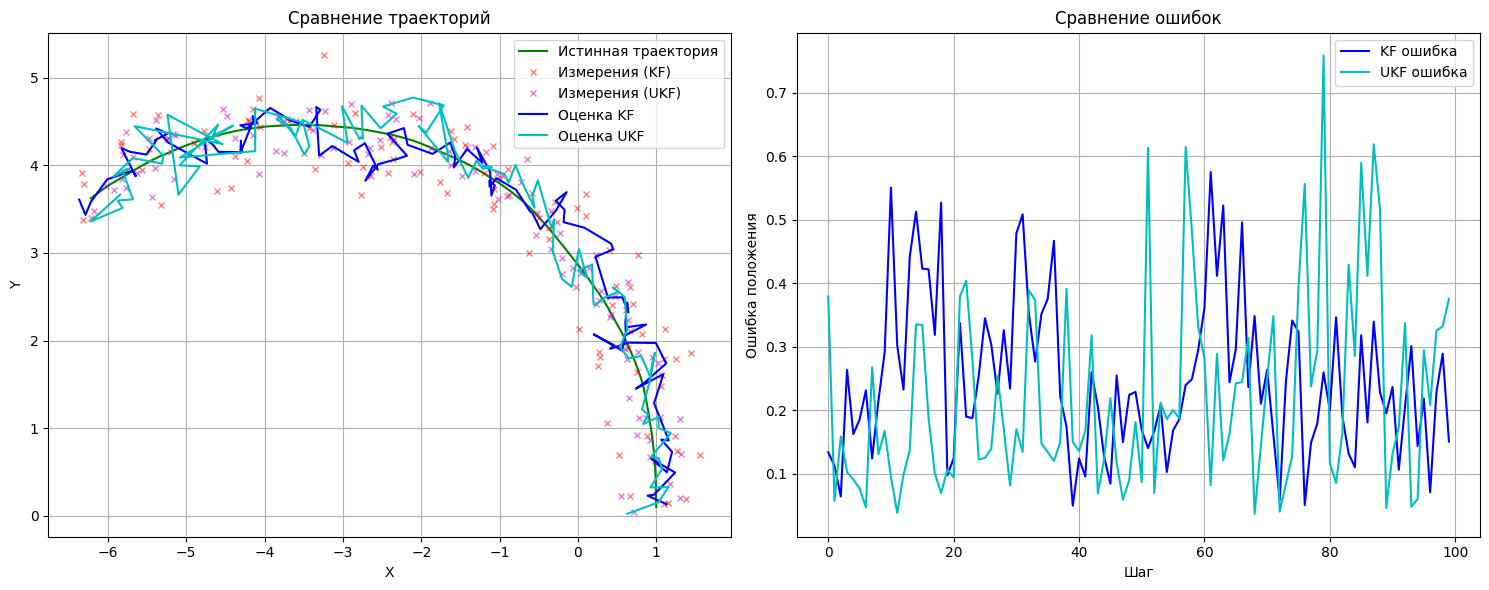

Среднеквадратичная ошибка KF: 0.2497
Среднеквадратичная ошибка UKF: 0.2218


In [3]:
import torch
import matplotlib.pyplot as plt
from filters import KalmanFilter, UnscentedKalmanFilter
from gaussian import GaussianState

# Параметры модели
dt = 0.1
state_dim = 4  # [x, y, vx, vy]
obs_dim = 2    # [x, y]

# 1. Инициализация фильтров ----------------------------------------------------

# UKF с нелинейными моделями
ukf = UnscentedKalmanFilter(state_dim=state_dim, obs_dim=obs_dim, alpha=1e-3, beta=2.0, kappa=0.0)

# KF с линеаризованными моделями
process_matrix = torch.eye(state_dim)
process_matrix[0, 2] = dt
process_matrix[1, 3] = dt
measurement_matrix = torch.zeros(obs_dim, state_dim)
measurement_matrix[0, 0] = 1
measurement_matrix[1, 1] = 1

process_noise_kf=torch.diag(torch.tensor([0.1, 0.1, 0.5, 0.5]))**2
measurement_noise_kf=torch.diag(torch.tensor([0.3, 0.3]))**2

kf = KalmanFilter(process_matrix=process_matrix,
                 measurement_matrix=measurement_matrix,
                 process_noise=process_noise_kf,
                 measurement_noise=measurement_noise_kf)  # Для KF используем декартовы координаты

# 2. Модели для UKF -----------------------------------------------------------

# Нелинейная модель процесса (движение с постоянной скоростью + поворот)
def process_model(sigma_points):
    # sigma_points shape: (..., 2*state_dim+1, state_dim, 1)
    new_points = sigma_points.clone()
    
    # Извлечение компонент состояния
    x = sigma_points[..., 0, 0]
    y = sigma_points[..., 1, 0]
    vx = sigma_points[..., 2, 0]
    vy = sigma_points[..., 3, 0]
    
    # Нелинейное преобразование - добавление поворота скорости
    speed = torch.sqrt(vx**2 + vy**2)
    angle = torch.atan2(vy, vx)
    new_angle = angle + 0.1 * dt  # небольшой поворот
    
    # Обновление скорости после поворота
    new_points[..., 2, 0] = speed * torch.cos(new_angle)
    new_points[..., 3, 0] = speed * torch.sin(new_angle)
    
    # Обновление позиции
    new_points[..., 0, 0] = x + new_points[..., 2, 0] * dt
    new_points[..., 1, 0] = y + new_points[..., 3, 0] * dt
    
    return new_points

# Нелинейная модель измерений (радиальные координаты)
def measurement_model(sigma_points):
    # sigma_points shape: (..., 2*state_dim+1, state_dim, 1)
    measurements = torch.zeros(*sigma_points.shape[:-2], obs_dim, 1)
    
    x = sigma_points[..., 0, 0]
    y = sigma_points[..., 1, 0]
    
    # Преобразование в полярные координаты (нелинейное измерение)
    r = torch.sqrt(x**2 + y**2)
    theta = torch.atan2(y, x)
    
    measurements[..., 0, 0] = r
    measurements[..., 1, 0] = theta
    
    return measurements

# Шумы
process_noise_ukf = torch.diag(torch.tensor([0.1, 0.1, 0.5, 0.5]))**2  # Q
measurement_noise_ukf = torch.diag(torch.tensor([0.3, 0.02]))**2      # R

# 3. Генерация данных ---------------------------------------------------------

# Общие параметры
initial_mean = torch.tensor([1.0, 0.0, 0.0, 1.0]).reshape(state_dim, 1)
initial_cov = torch.diag(torch.tensor([0.5, 0.5, 0.5, 0.5]))
initial_state = GaussianState(initial_mean, initial_cov)

# Генерация истинной траектории и измерений
num_steps = 100
true_states = torch.zeros(num_steps, state_dim, 1)
measurements_polar = torch.zeros(num_steps, obs_dim, 1)  # Для UKF
measurements_cart = torch.zeros(num_steps, obs_dim, 1)   # Для KF

current_state = initial_mean.clone()
for t in range(num_steps):
    # Истинная динамика (с небольшим случайным поворотом)
    x, y, vx, vy = current_state.squeeze()
    speed = torch.sqrt(vx**2 + vy**2)
    angle = torch.atan2(vy, vx)
    new_angle = angle + 0.2 * dt + 0.02 * torch.randn(1)
    
    current_state[2] = speed * torch.cos(new_angle)
    current_state[3] = speed * torch.sin(new_angle)
    current_state[0] += current_state[2] * dt
    current_state[1] += current_state[3] * dt
    
    # Сохраняем истинное состояние
    true_states[t] = current_state.clone()
    
    # Генерируем измерение с шумом
    r = torch.sqrt(current_state[0]**2 + current_state[1]**2)
    theta = torch.atan2(current_state[1], current_state[0])
    measurements_polar[t, 0] = r + measurement_noise_ukf[0, 0].sqrt() * torch.randn(1)
    measurements_polar[t, 1] = theta + measurement_noise_ukf[1, 1].sqrt() * torch.randn(1)
    measurements_cart[t, 0] = current_state[0] + measurement_noise_kf[0, 0].sqrt() * torch.randn(1)
    measurements_cart[t, 1] = current_state[1] + measurement_noise_kf[1, 1].sqrt() * torch.randn(1)

# 4. Запуск фильтров ----------------------------------------------------------

# UKF
ukf_means = torch.zeros(num_steps, state_dim, 1)
ukf_covs = torch.zeros(num_steps, state_dim, state_dim)
ukf_state = initial_state

# KF
kf_means = torch.zeros(num_steps, state_dim, 1)
kf_covs = torch.zeros(num_steps, state_dim, state_dim)
kf_state = initial_state

for t in range(num_steps):
    # UKF обработка
    ukf_state = ukf.predict_update(
        ukf_state,
        measurements_polar[t],
        process_model,
        process_noise_ukf,
        measurement_model,
        measurement_noise_ukf
    )
    ukf_means[t] = ukf_state.mean
    ukf_covs[t] = ukf_state.covariance
    
    # KF обработка
    kf_state = kf.predict(kf_state)
    kf_state = kf.update(kf_state, measurements_cart[t])
    kf_means[t] = kf_state.mean
    kf_covs[t] = kf_state.covariance

# 5. Визуализация результатов -------------------------------------------------

plt.figure(figsize=(15, 6))

# Траектория XY
plt.subplot(1, 2, 1)
plt.plot(true_states[:, 0, 0], true_states[:, 1, 0], 'g-', label='Истинная траектория')
plt.plot(measurements_cart[:, 0, 0], measurements_cart[:, 1, 0], 
         'rx', label='Измерения (KF)', markersize=4, alpha=0.5)
plt.plot(measurements_polar[:, 0, 0] * torch.cos(measurements_polar[:, 1, 0]),
         measurements_polar[:, 0, 0] * torch.sin(measurements_polar[:, 1, 0]),
         'mx', label='Измерения (UKF)', markersize=4, alpha=0.5)
plt.plot(kf_means[:, 0, 0], kf_means[:, 1, 0], 'b-', label='Оценка KF')
plt.plot(ukf_means[:, 0, 0], ukf_means[:, 1, 0], 'c-', label='Оценка UKF')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Сравнение траекторий')
plt.legend()
plt.grid(True)

# Ошибки положения
kf_errors = torch.sqrt((kf_means[:, 0, 0] - true_states[:, 0, 0])**2 + 
                       (kf_means[:, 1, 0] - true_states[:, 1, 0])**2)
ukf_errors = torch.sqrt((ukf_means[:, 0, 0] - true_states[:, 0, 0])**2 + 
                        (ukf_means[:, 1, 0] - true_states[:, 1, 0])**2)

plt.subplot(1, 2, 2)
plt.plot(kf_errors, 'b-', label='KF ошибка')
plt.plot(ukf_errors, 'c-', label='UKF ошибка')
plt.xlabel('Шаг')
plt.ylabel('Ошибка положения')
plt.title('Сравнение ошибок')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Вывод среднеквадратичных ошибок
print(f"Среднеквадратичная ошибка KF: {kf_errors.mean().item():.4f}")
print(f"Среднеквадратичная ошибка UKF: {ukf_errors.mean().item():.4f}")